# Clustering ETFs

This notebook contains the required code to perform the pairs selection stage. First, it implements the three following search techniques:

- No clustering
- Clustering by category
- Clustering with OPTICS

In addittion, it considers the proposed pairs selection rules to apply on top.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

### Import Libraries

In [1]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.random.set_seed(2) # Tensorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import *

from sklearn.manifold import TSNE

from keras.layers import Dense, Flatten, LSTM, Dropout

os.getcwd()
os.chdir('c:\\PairsTrading')

### Import Classes

In [3]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [4]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Commodity ETFs Dataset

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [5]:
# intraday
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened.pickle')
# df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')
df_prices = pd.read_hdf('df_prices_train.h5')

subsample = 2500
min_half_life = 78 # number of points in a day
max_half_life = 20000 #~number of points in a year: 78*252
file_extension = 'intraday'

In [6]:
len(df_prices.columns)

764

In [8]:
initial_train_date = '2016-01-01'
final_train_date = '2017-12-31'
initial_test_date = '2018-01-01'
final_test_date = '2018-07-01'


serial_time = df_prices.DATA.copy()
df_prices.DATA = df_prices.DATA.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_prices.set_index('DATA', inplace=True, drop=False)

In [17]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            (initial_train_date,
                                                             final_train_date),
                                                            (initial_test_date,
                                                             final_test_date),
                                                            remove_nan=True)
train_val_split = '2018-06-30'

Total of 764 tickers
Total of 764 tickers after removing tickers with Nan values


In [18]:
len(df_prices_train)+len(df_prices_test)

29136

In [19]:
df_prices_train = df_prices_train.iloc[:,2:]

# 1. No Clustering

In [20]:
# no_cluster_series = pd.Series(0,index = df_prices_train.columns)
# pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
#                                                             pricing_df_train=df_prices_train,
#                                                             pricing_df_test=df_prices_test,
#                                                             min_half_life=min_half_life,
#                                                             max_half_life=max_half_life,
#                                                             min_zero_crosings=12,
#                                                             p_value_threshold=0.05,
#                                                             hurst_threshold=0.5,
#                                                             subsample=subsample,    
#                                                             )

In [21]:
print('Out of {} possible combinations'.format(len(df_prices_train.columns)*(len(df_prices_train.columns)-1)/2))
#with open('data/etfs/pickle/2014-2018/pairs_no_clustering_'+file_extension+'_only_coint.pickle', 'wb') as f:
#    pickle.dump(pairs_all_a_all, f)

Out of 289941.0 possible combinations


# 2. Clustering by Category

In [22]:
segment_mapper = {
                'Commodities: Agriculture':'Agriculture',
                'Commodities: Agriculture Cocoa':'Agriculture',
                'Commodities: Agriculture Coffee':'Agriculture',
                'Commodities: Agriculture Corn':'Agriculture',
                'Commodities: Agriculture Cotton':'Agriculture',
                'Commodities: Agriculture Grains':'Agriculture',
                'Commodities: Agriculture Livestock':'Agriculture',
                'Commodities: Agriculture Softs':'Agriculture',
                'Commodities: Agriculture Soybeans':'Agriculture',
                'Commodities: Agriculture Sugar':'Agriculture',
                'Commodities: Agriculture Wheat':'Agriculture',
                'Equity: Global Water':'Agriculture',
                'Commodities: Broad Market':'Broad Market',
                'Commodities: Broad Market Metals':'Broad Market',
                'Commodities: Energy':'Energy',
                'Commodities: Energy Crude Oil':'Energy',
                'Commodities: Energy Gasoline':'Energy',
                'Commodities: Energy Natural Gas':'Energy',
                'Inverse Commodities: Energy Crude Oil':'Energy',
                'Inverse Commodities: Energy Natural Gas':'Energy',
                'Leveraged Commodities: Energy Crude Oil':'Energy',
                'Leveraged Commodities: Energy Natural Gas':'Energy',
                'Equity: U.S. MLPs':'Energy',
                'Equity: U.S. Energy':'Energy',
                'Inverse Equity: U.S. Energy':'Energy',
                'Inverse Equity: U.S. Natural Gas':'Energy',
                'Equity: U.S. Oil & Gas Exploration & Production':'Energy',
                'Equity: U.S. Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Oil & Gas Exploration & Production':'Energy',
                'Equity: Global Energy':'Energy',
                'Equity: Global Nuclear Energy':'Energy',
                'Equity: Global Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Oil & Gas':'Energy',
                'Equity: U.S. Natural Gas':'Energy',
                'Equity: Global Coal':'Energy',
                'Leveraged Equity: U.S. Energy':'Energy',
                'Leveraged Equity: U.S. Natural Gas':'Energy',
                'Equity: China Energy':'Energy',
                'Leveraged Equity: U.S. Natural Gas':'Energy',
                'Commodities: Industrial Metals':'Industrial Metals',
                'Commodities: Industrial Metals Aluminum':'Industrial Metals',
                'Commodities: Industrial Metals Copper':'Industrial Metals',
                'Commodities: Industrial Metals Lead':'Industrial Metals',
                'Commodities: Industrial Metals Nickel':'Industrial Metals',
                'Commodities: Industrial Metals Tin':'Industrial Metals',
                'Equity: U.S. Metals & Mining':'Industrial Metals',
                'Equity: Global Metals & Mining':'Industrial Metals',
                'Commodities: Precious Metals':'Precious Metals',
                'Commodities: Precious Metals Gold':'Precious Metals',
                'Commodities: Precious Metals Palladium':'Precious Metals',
                'Commodities: Precious Metals Platinum':'Precious Metals',
                'Commodities: Precious Metals Silver':'Precious Metals',
                'Inverse Commodities: Precious Metals Gold':'Precious Metals',
                'Inverse Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Commodities: Precious Metals Gold': 'Precious Metals',
                'Leveraged Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Equity: Global Gold Miners':'Precious Metals',
                'Equity: Global Gold Miners':'Precious Metals',
                'Equity: Global Silver Miners':'Precious Metals',
                'Inverse Equity: Global Gold Miners':'Precious Metals'}

clustering_mapper = {'Agriculture':0,'Energy':1, 'Industrial Metals':2, 'Precious Metals':3, 'Broad Market': 4}

In [23]:
# df_category.to_csv('ss.csv')

In [24]:
ticker_path = "data/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

df_category = pd.DataFrame(data =df_prices_train.columns, columns=['Ticker'])
df_category['Segment'] = df_category['Ticker'].apply(lambda row: ticker_segment_dict[row])
# df_category['Category'] = df_category['Segment'].apply(lambda row: segment_mapper[row])
# df_category['Category_cluster'] = df_category['Segment'].apply(lambda row: clustering_mapper[row])
df_category = df_category.set_index('Ticker')

ticker_category_dict = pd.Series(df_category.Segment.values,index=df_category.index).to_dict()
with open('data/ticker_category_dict.pickle', 'wb') as handle:
    pickle.dump(ticker_category_dict, handle)

In [25]:
pd.set_option('max_columns',1000) 

In [26]:
print('Trading days: ', len(np.unique(df_prices_train.index))+len(np.unique(df_prices_test.index)))
print('Begin: ', df_prices_train.index[0])
print('End: ', df_prices_test.index[-1])
print('Samples: {}: {}-{}-{} '.format(len(df_prices_train+df_prices_test), len(df_prices_train[:train_val_split]),
                                      len(df_prices_train[train_val_split:]), len(df_prices_test)))
print(df_category['Segment'].value_counts())
combinations = 0
for i,count in enumerate(df_category['Segment'].value_counts().values):
    combinations += count*(count-1)
print('Possible number of pairs: ', combinations)

Trading days:  607
Begin:  2016-01-04 00:00:00
End:  2018-06-29 00:00:00
Samples: 29136: 23424-0-5712 
电气设备    35
中成药     28
软件服务    27
化工原料    25
元器件     23
        ..
染料涂料     1
其他商业     1
电器连锁     1
铜        1
酒店餐饮     1
Name: Segment, Length: 103, dtype: int64
Possible number of pairs:  9498


In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_category.drop(['Segment'],axis=1))

Empty DataFrame
Columns: []
Index: [SZ000001, SZ000005, SZ000009, SZ000010, SZ000011, SZ000012, SZ000014, SZ000027, SZ000036, SZ000039, SZ000049, SZ000055, SZ000069, SZ000070, SZ000078, SZ000088, SZ000089, SZ000090, SZ000096, SZ000400, SZ000402, SZ000417, SZ000419, SZ000421, SZ000423, SZ000501, SZ000514, SZ000518, SZ000525, SZ000528, SZ000529, SZ000530, SZ000532, SZ000536, SZ000539, SZ000541, SZ000548, SZ000550, SZ000552, SZ000554, SZ000567, SZ000570, SZ000572, SZ000573, SZ000581, SZ000589, SZ000591, SZ000596, SZ000597, SZ000598, SZ000600, SZ000607, SZ000620, SZ000628, SZ000630, SZ000631, SZ000632, SZ000637, SZ000668, SZ000680, SZ000683, SZ000685, SZ000692, SZ000698, SZ000701, SZ000702, SZ000705, SZ000709, SZ000715, SZ000722, SZ000725, SZ000726, SZ000729, SZ000731, SZ000738, SZ000739, SZ000751, SZ000753, SZ000758, SZ000759, SZ000762, SZ000768, SZ000776, SZ000777, SZ000778, SZ000783, SZ000785, SZ000788, SZ000789, SZ000791, SZ000798, SZ000800, SZ000801, SZ000811, SZ000819, SZ000822, SZ00

In [28]:
pairs_category, unique_tickers = series_analyser.get_candidate_pairs(
                                                            clustered_series=df_category['Segment'],
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=20,
                                                            p_value_threshold=0.05,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample,
                                                            )

pairs_found_category = len(pairs_category)
#with open('data/etfs/pickle/2012-2016/pairs_category_'+file_extension+'.pickle', 'wb') as f:
#    pickle.dump(pairs_category, f)

Cluster 103/103Found 0 pairs
The pairs contain 0 unique tickers
Pairs Selection failed stage:  {}


# 3. Clustering using Usupervised Learning

## PCA on returns

**Obtain returns**

In [30]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,SZ000001,SZ000005,SZ000009,SZ000010,SZ000011,SZ000012,SZ000014,SZ000027,SZ000036,SZ000039,SZ000049,SZ000055,SZ000069,SZ000070,SZ000078,SZ000088,SZ000089,SZ000090,SZ000096,SZ000400,SZ000402,SZ000417,SZ000419,SZ000421,SZ000423,SZ000501,SZ000514,SZ000518,SZ000525,SZ000528,SZ000529,SZ000530,SZ000532,SZ000536,SZ000539,SZ000541,SZ000548,SZ000550,SZ000552,SZ000554,SZ000567,SZ000570,SZ000572,SZ000573,SZ000581,SZ000589,SZ000591,SZ000596,SZ000597,SZ000598,SZ000600,SZ000607,SZ000620,SZ000628,SZ000630,SZ000631,SZ000632,SZ000637,SZ000668,SZ000680,SZ000683,SZ000685,SZ000692,SZ000698,SZ000701,SZ000702,SZ000705,SZ000709,SZ000715,SZ000722,SZ000725,SZ000726,SZ000729,SZ000731,SZ000738,SZ000739,SZ000751,SZ000753,SZ000758,SZ000759,SZ000762,SZ000768,SZ000776,SZ000777,SZ000778,SZ000783,SZ000785,SZ000788,SZ000789,SZ000791,SZ000798,SZ000800,SZ000801,SZ000811,SZ000819,SZ000822,SZ000823,SZ000828,SZ000830,SZ000837,SZ000839,SZ000848,SZ000850,SZ000852,SZ000858,SZ000860,SZ000861,SZ000869,SZ000875,SZ000880,SZ000886,SZ000888,SZ000895,SZ000897,SZ000908,SZ000910,SZ000915,SZ000919,SZ000921,SZ000937,SZ000949,SZ000951,SZ000952,SZ000957,SZ000958,SZ000965,SZ000966,SZ000970,SZ000978,SZ000983,SZ000985,SZ000989,SZ000996,SZ000999,SZ001979,SZ002007,SZ002008,SZ002022,SZ002023,SZ002027,SZ002028,SZ002030,SZ002038,SZ002039,SZ002041,SZ002042,SZ002043,SZ002054,SZ002056,SZ002060,SZ002064,SZ002066,SZ002067,SZ002079,SZ002081,SZ002083,SZ002088,SZ002090,SZ002093,SZ002095,SZ002096,SZ002105,SZ002107,SZ002111,SZ002114,SZ002116,SZ002117,SZ002118,SZ002119,SZ002133,SZ002136,SZ002138,SZ002139,SZ002140,SZ002144,SZ002146,SZ002148,SZ002149,SZ002154,SZ002166,SZ002169,SZ002170,SZ002172,SZ002177,SZ002179,SZ002182,SZ002185,SZ002187,SZ002195,SZ002200,SZ002202,SZ002204,SZ002208,SZ002214,SZ002215,SZ002216,SZ002218,SZ002222,SZ002227,SZ002229,SZ002232,SZ002234,SZ002236,SZ002237,SZ002241,SZ002244,SZ002250,SZ002253,SZ002262,SZ002268,SZ002271,SZ002273,SZ002275,SZ002276,SZ002277,SZ002281,SZ002292,SZ002294,SZ002296,SZ002298,SZ002302,SZ002304,SZ002305,SZ002307,SZ002311,SZ002315,SZ002317,SZ002322,SZ002325,SZ002327,SZ002328,SZ002334,SZ002337,SZ002351,SZ002361,SZ002362,SZ002364,SZ002365,SZ002367,SZ002372,SZ002375,SZ002378,SZ002380,SZ002391,SZ002393,SZ002394,SZ002401,SZ002410,SZ002412,SZ002414,SZ002415,SZ002416,SZ002419,SZ002421,SZ002422,SZ002424,SZ002428,SZ002441,SZ002444,SZ002446,SZ002448,SZ002449,SZ002455,SZ002457,SZ002461,SZ002463,SZ002467,SZ002472,SZ002474,SZ002481,SZ002484,SZ002487,SZ002488,SZ002489,SZ002493,SZ002495,SZ002497,SZ002498,SZ002500,SZ002501,SZ002503,SZ002508,SZ002511,SZ002518,SZ002519,SZ002522,SZ002531,SZ002534,SZ002536,SZ002539,SZ002541,SZ002546,SZ002549,SZ002550,SZ002559,SZ002561,SZ002563,SZ002572,SZ002577,SZ002588,SZ002589,SZ002590,SZ002593,SZ002594,SZ002595,SZ002597,SZ002603,SZ002620,SZ002634,SZ002641,SZ002643,SZ002644,SZ002645,SZ002646,SZ002649,SZ002651,SZ002653,SZ002657,SZ002660,SZ002674,SZ002677,SZ002687,SZ002689,SZ002690,SZ002700,SZ002702,SZ002705,SZ002706,SZ002718,SZ002728,SZ002734,SZ002736,SZ002737,SZ002741,SZ002743,SZ002746,SZ002749,SZ002750,SZ002753,SZ002763,SZ002773,SZ002782,SZ002783,SZ002786,SZ300002,SZ300006,SZ300007,SZ300009,SZ300014,SZ300024,SZ300029,SZ300037,SZ300039,SZ300048,SZ300066,SZ300078,SZ300079,SZ300094,SZ300105,SZ300107,SZ300114,SZ300119,SZ300122,SZ300124,SZ300126,SZ300127,SZ300129,SZ300133,SZ300136,SZ300138,SZ300139,SZ300141,SZ300147,SZ300154,SZ300155,SZ300170,SZ300171,SZ300172,SZ300174,SZ300181,SZ300183,SZ300188,SZ300193,SZ300199,SZ300203,SZ300204,SZ300205,SZ300206,SZ300210,SZ300214,SZ300217,SZ300218,SZ300228,SZ300232,SZ300241,SZ300249,SZ300258,SZ300263,SZ300275,SZ300286,SZ300305,SZ300314,SZ300318,SZ300321,SZ300327,SZ300333,SZ300346,SZ300354,SZ300357,SZ300371,SZ300378,SZ300380,SZ300386,SZ300389,SZ300395,SZ300396,SZ300397,SZ300399,SZ300400,SZ300403,SZ300415,SZ300417,SZ300435,SZ300439,SZ300442,SZ300445,SZ300446,SZ300452,SZ300470,SZ300485,SZ300489,SZ300494,SZ300497,SH600004,SH600007,SH600009,SH600011,SH600015,SH600016,SH600017,SH600020,SH600023,SH600027,SH600028,SH6

In [31]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  289941.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 5.

In [32]:
N_PRIN_COMPONENTS = 5
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns, 
                                                  random_state=0)#12)
print(explained_variance)

[3.30861968e-03 5.39640836e-04 9.03838032e-05 7.25478473e-05
 5.80724765e-05]


**Clustering**

In [33]:
def cluster_size(counts):
    plt.figure()
    plt.barh(counts.index+1, counts.values)
    #plt.title('Cluster Member Counts')
    plt.yticks(np.arange(1, len(counts)+1, 1))
    plt.xlabel('trickers within cluster', size=12)
    plt.ylabel('Cluster Id', size=12);

In [34]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(0.15,
                                                                                   3,
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 5
Pairs to evaluate: 21


In [36]:
# optics
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_OPTICS(X, df_returns, min_samples=3,
                                                                                   #max_eps=5, 
                                                                                   cluster_method='xi')

OPTICS(max_eps=2, metric='euclidean', min_samples=3)
Clusters discovered: 62
Pairs to evaluate: 517


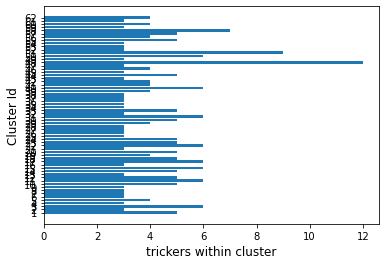

In [37]:
cluster_size(counts)

The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [38]:
print(counts)
print('Average cluster size: ', np.mean(counts))

47    12
50     9
57     7
2      6
39     6
      ..
36     3
35     3
34     3
33     3
31     3
Length: 62, dtype: int64
Average cluster size:  4.274193548387097


**Fundamental analysis for clusters**

In [39]:
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(path='data/STTT.csv')

In [40]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
        Ticker Segment
0     SZ000001      银行
797   SZ002304      白酒
3501  SH601006      铁路
3577  SH601318      保险
3613  SH601601      保险

Cluster 1:
        Ticker Segment
2718  SH600016      银行
2736  SH600036      银行
3110  SH600519      白酒

Cluster 2:
        Ticker Segment
2728  SH600027    火力发电
2756  SH600066    汽车整车
2922  SH600269      路桥
3215  SH600642    火力发电
3240  SH600674    水力发电
3710  SH601998      银行

Cluster 3:
        Ticker Segment
263   SZ000729      啤酒
1080  SZ002595    专用机械
3180  SH600600      啤酒

Cluster 4:
        Ticker Segment
136   SZ000550    汽车整车
787   SZ002294    化学制药
914   SZ002422    化学制药
3524  SH601098     出版业

Cluster 5:
        Ticker Segment
3551  SH601179    电气设备
3582  SH601333      铁路
3701  SH601985    新型电力

Cluster 6:
        Ticker Segment
404   SZ000951    汽车整车
3164  SH600583    石油开采
3559  SH601211      证券

Cluster 7:
        Ticker Segment
163   SZ000589    汽车配件
2966  SH600323    环境保护
3385  SH600837      证券

Cluster 8:
        Ticker Seg

**Visualizing with t-sne**

In [56]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    
    X_tsne = TSNE(learning_rate=100, perplexity=25, random_state=1337).fit_transform(X)
    
    # visualization
    fig = plt.figure(1, facecolor='white', figsize=(15,15), frameon=True, edgecolor='black')
    plt.clf()
    
    # axis in the middle
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)
    #plt.axis('off')

    # etfs in cluster
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=300,
        alpha=0.75,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    # for i, ticker in enumerate(tickers):
    #     plt.annotate(ticker, (x[i]-20, y[i]+12), size=15)

    # remaining etfs, not clustered
    x = X_tsne[(clustered_series_all==-1).values, 0]
    y = X_tsne[(clustered_series_all==-1).values, 1]
    tickers = list(clustered_series_all[clustered_series_all == -1].index)

    # WARNING: elimintate outliers
    #outliers = ['DTO','SCO']
    outliers = ['SZ000049', 'SH603288']
    to_remove_x = [x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    to_remove_y = [y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    x = np.array([i for i in x if i not in to_remove_x])
    y= np.array([i for i in y if i not in to_remove_y])

    plt.scatter(
        x,
        y,
        s=150,
        alpha=0.20,
        c='black'
    )
    #for i, ticker in enumerate(tickers):
    #    plt.annotate(ticker, (x[i]+20, y[i]+20))#, arrowprops={'arrowstyle':'simple'})
        
    #plt.title('OPTICS clusters visualized with t-SNE', size=16);
    plt.xlabel('t-SNE Dim. 1', position=(0.92,0), size=20)
    plt.ylabel('t-SNE Dim. 2', position=(0,0.92), size=20)
    #plt.savefig('DBSCAN_2014_2018_eps0_15.png', bbox_inches='tight', pad_inches=0.01)
    plt.savefig('OPTICS_2013_2017.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # include connections - see quontopian

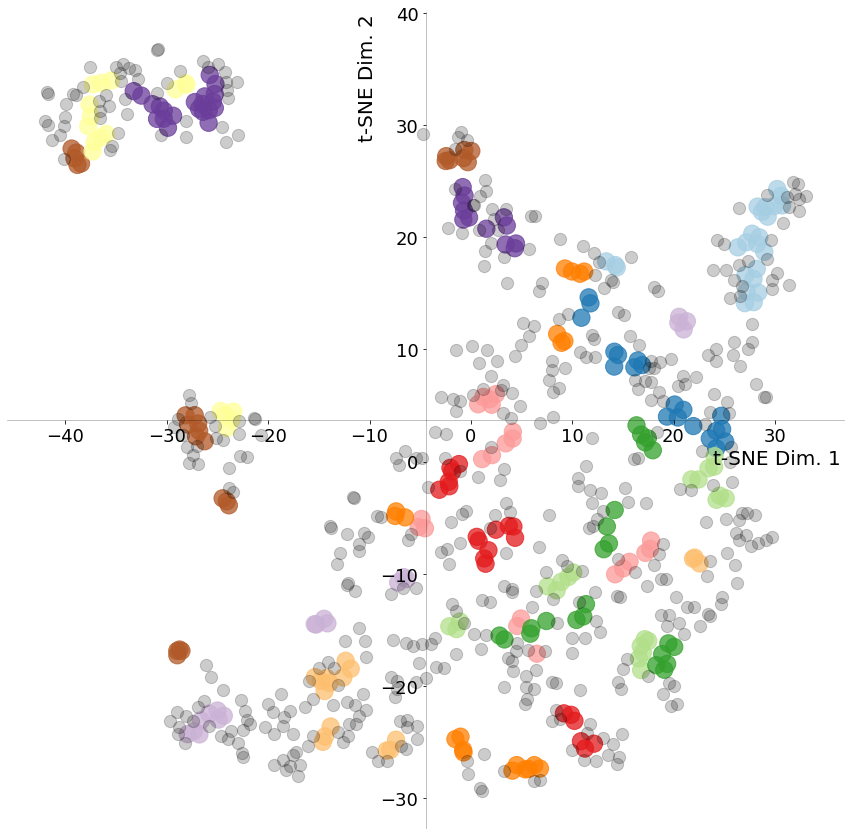

In [57]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

In [58]:
plt.rcParams.update({'font.size': 12})

In [59]:
len(counts)

62

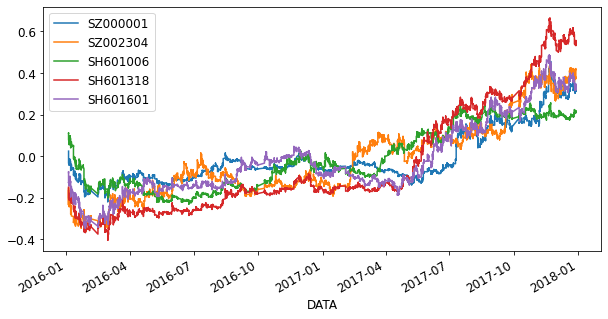

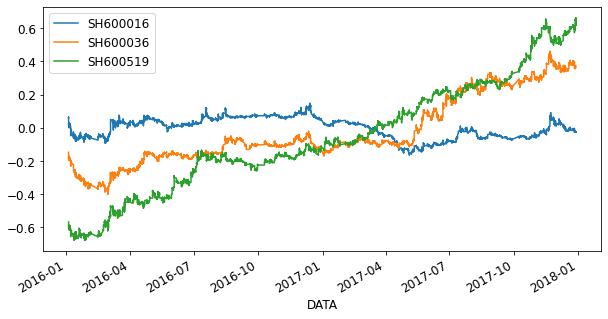

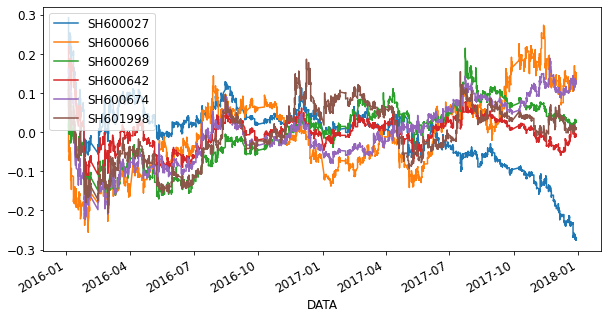

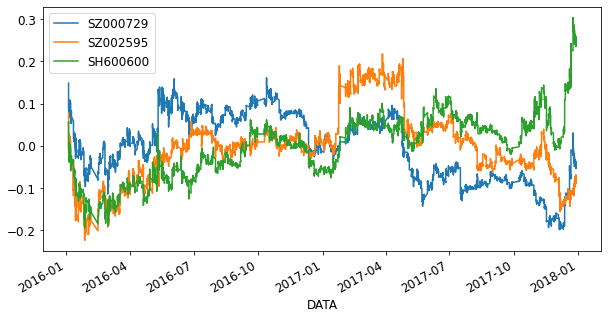

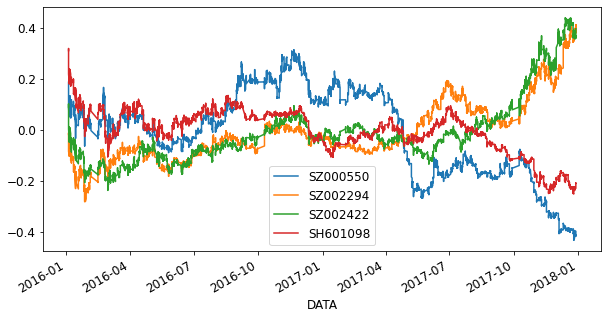

In [60]:
for clust in range(5):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(figsize=(10,5))#title='ETFs Time Series for Cluster %d' % (clust+1))
    #plt.ylabel('Normalized log prices', size=12)
    #plt.xlabel('Date', size=12)
    plt.savefig('cluster_{}.png'.format(str(clust+1)), bbox_inches='tight', pad_inches=0.1)

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [61]:
pairs_unsupervised, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=12,
                                                            p_value_threshold=0.10,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample
                                                            )

Cluster 62/62Found 117 pairs
The pairs contain 132 unique tickers
Pairs Selection failed stage:  {'cointegration': 387, 'None': 117, 'hurst_exponent': 13}


In [ ]:
pairs_unsupervised, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=12,
                                                            p_value_threshold=0.10,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample
                                                            )

Cluster 62/62Found 117 pairs
The pairs contain 132 unique tickers
Pairs Selection failed stage:  {'cointegration': 387, 'None': 117, 'hurst_exponent': 13}


In [62]:
with open('data/etfs/pickle/2016-2018/pairs_unsupervised_learning_optical_'+file_extension+'_p005_seed0.pickle', 'wb') as f:
    pickle.dump(pairs_unsupervised, f)